# Aerial Project

<img src="img/logo.jpg" width=150 ALIGN="left" border="20">

## Starting Kit for raw data (images)

Created by Aerial Team

ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE.

## Introduction

Aerial imagery has been a primary source of geographic data for quite a long time. With technology progress, aerial imagery became really practical for remote sensing : the science of obtaining information about an object, area or phenomenon.
Nowadays, there are many uses of image recognition spanning from robotics/drone vision to autonomous driving vehicules or face detection.

In this challenge, we will use pre-processed data, coming from landscape images. The goal is to learn to differentiate common and uncommon landscapes such as a beach, a lake or a meadow.
Data comes from part of the data set (NWPU-RESISC45) originally used in the paper [*Remote Sensing Image Scene Classification*](https://arxiv.org/pdf/1703.00121.pdf). This data set contains 45 categories while we only kept 13 out of them.

**Challenge website:** https://codalab.lisn.upsaclay.fr/competitions/573#participate-submit_results

References and credits:

Yuliya Tarabalka, Guillaume Charpiat, Nicolas Girard for the data sets presentation.<br>
Gong Cheng, Junwei Han, and Xiaoqiang Lu, for the original article on the chosen data set.
</div>

### Requirements / Installation

```bash
conda create -n torch python=3
conda activate torch
conda install pytorch torchvision torchaudio -c pytorch
conda install ipykernel pyyaml pandas matplotlib scipy scikit-learn
```

Code tested with:

```
python=3.9.7
pytorch=1.10.0
pyyaml=6.0
pandas=1.3.4
matplotlib=3.5.0
scipy=1.7.1
scikit-learn=1.0.1
```

In [1]:
import csv
import platform
import shutil
from collections import namedtuple
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import decomposition, metrics, model_selection, naive_bayes, pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.0.1

0.23.2


In [3]:
SUBM_PATH = Path("submissions")
MODEL_PATH = Path("submission_code")
SCORE_PATH = Path("scoring_output")
DATA_PATH = Path("sample_data")         # Sample dataset
DATA_PATH = Path("public_data")      # Uncomment to use full dataset

RESULTS_PATH = SUBM_PATH / "submission_results"

DATA_NAME = "Areal"

DATA_SETS = ["train", "test"]
ALL_SETS = ["train", "valid", "test"]

## Step 1: Exploratory data analysis

We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.

**<span style="color:red">Warning</span>**

*In case you want to load the full data*

Files being big, your computer needs to have enough space available in your RAM. It should take about 3-4GB while loading and 1.5GB in the end.

### Load data

In [4]:
def number_lines(fname):
    with open(fname) as f:
        return sum(1 for l in f)

In [5]:
def fast_import(arr, fpath):
    with open(fpath) as f:
        for i, row in enumerate(csv.reader(f, delimiter=" ")):
            arr[i] = row

In [6]:
num_fts = number_lines(DATA_PATH / f"{DATA_NAME}_feat.name")

num = {
    data_set: number_lines(DATA_PATH / f"{DATA_NAME}_{data_set}.data")
    for data_set in ALL_SETS
}

xs_raw = {
    data_set: np.empty((num[data_set], num_fts))
    for data_set in ALL_SETS
}

for data_set in ALL_SETS:
    fast_import(
        xs_raw[data_set], 
        fpath=DATA_PATH / f"{DATA_NAME}_{data_set}.data"
    )

In [7]:
labels_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_label.name", header=None, names=["name"]
)

labels = labels_df.name.to_list()

ys_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_train.solution", header=None, names=["value"]
)

ys_raw = ys_df.values

ys_df["label"] = ys_df.value.map(labels_df.name)

ys_df.head()

,value,label
0,5,island
1,0,beach
2,0,beach
3,1,chaparral
4,0,beach


### Visualize dataset sample

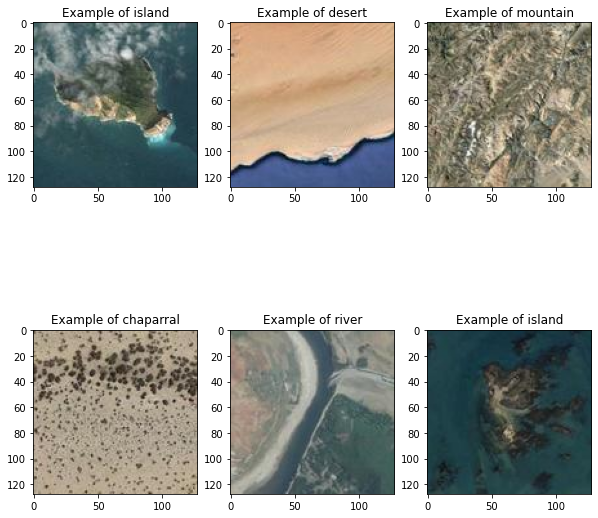

In [8]:
NUM_TO_SHOW = 6

fig, axs_ = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
fig.subplots_adjust(hspace=0.3)
axs = axs_.flatten()

for i in range(NUM_TO_SHOW):
    idx = np.random.randint(5000)
    img = xs_raw["train"][idx].reshape(128, 128, -1)
    label = ys_df.label[idx]
    axs[i].set_title(f"Example of {label}")
    axs[i].imshow(img.astype(float) / 255)

plt.show()


## Step 2 : Building a predictive model

### Baseline model

In [9]:
print(xs_raw['test'].shape)

(1950, 49152)


We split the dataset in 3: the train set, the validation set and the test set for submission on Codalab

In [10]:
xs, ys = {}, {}

xs["train"], xs["valid"], ys["train"], ys["valid"] = model_selection.train_test_split(
    xs_raw["train"], ys_raw, random_state=1
)

xs["test"] = xs_raw["test"]

print(xs_raw["train"].shape, ys_raw.shape)
print(xs["train"].shape, ys["train"].shape)
print(xs["valid"].shape, ys["valid"].shape)
print(xs["test"].shape)

(5200, 49152) (5200, 1)
(3900, 49152) (3900, 1)
(1300, 49152) (1300, 1)
(1950, 49152)


In [11]:
print(xs_raw)

{'train': array([[109., 134., 112., ..., 107., 127., 102.],
       [ 68.,  73.,  66., ..., 115., 108., 100.],
       [119., 142., 122., ..., 134., 135., 140.],
       ...,
       [179., 164., 145., ..., 161., 146., 125.],
       [ 93., 113.,  88., ...,  62.,  88.,  59.],
       [133., 130., 121., ..., 114., 112.,  97.]]), 'valid': array([[ 14.,  14.,  16., ...,  85.,  86.,  90.],
       [152., 148., 123., ..., 144., 133., 113.],
       [199., 198., 194., ...,  47.,  81.,  90.],
       ...,
       [ 24.,  25.,  29., ...,  32.,  33.,  37.],
       [ 22.,  38.,  37., ...,  26.,  38.,  38.],
       [130., 134., 137., ..., 211., 194., 178.]]), 'test': array([[ 60.,  85., 125., ...,  65.,  89., 135.],
       [ 56.,  87.,  56., ...,  42.,  60.,  38.],
       [ 51.,  75.,  53., ...,  34.,  66.,  51.],
       ...,
       [ 63.,  71.,  60., ...,  61.,  66.,  62.],
       [ 68.,  96., 108., ..., 190., 176., 163.],
       [ 73.,  73.,  71., ..., 155., 142., 126.]])}


We verify there are no NaN in the dataset

In [12]:
print(pd.isna(xs['train']).any())
print(pd.isna(ys['train']).any())
print(pd.isna(xs['valid']).any())
print(pd.isna(ys['valid']).any())
print(pd.isna(xs['test']).any())

#There are no NaN

False
False
False
False
False


In [13]:
print(ys["train"].shape)

(3900, 1)


We encode the labels in one hot vectors to fit the requirements of a neural network

In [14]:
def encode(ds):
    nb_cat = 13
    ret = np.zeros((ds.shape[0], nb_cat))
    for i in range(ds.shape[0]):
        ret[i][ds[i]] = 1
    return ret
    

In [15]:
#Encoding

for typ in ["train","valid"]:
    ys[typ] = encode(ys[typ])

In [16]:
print(ys['train'].shape)

(3900, 13)


Plotting the label frequency

<BarContainer object of 13 artists>

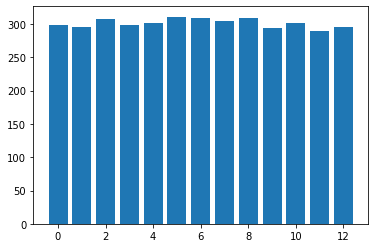

In [17]:
plt.bar(np.arange(0,13,1),sum(ys['train'], 1))

The dataset is well balanced

We standardise the dataset using min-max standardisation

In [18]:
#Standardisation

sd_max = max([max(xs['train'][i]) for i in range(xs['train'].shape[0])])
sd_min = min([min(xs['train'][i]) for i in range(xs['train'].shape[0])])

print(f"Max: {sd_max}")
print(f"Min: {sd_min}")


for typ in ["train","valid","test"]:
    xs[typ] = (xs[typ] - sd_min)/sd_max

Max: 255.0
Min: 0.0


We import Pytorch tools

In [19]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
from torchvision import transforms
import psutil

We convert our data in Pytorch Tensors to be able to use Pytorch

In [20]:
#Data transformation to Tensors

image_train = []
label_train = []

for image in xs['train']:
    image_train.append(ToTensor()(image.reshape(128,128,-1)))

image_train = torch.stack(image_train)
label_train = torch.FloatTensor(ys['train'])

In [21]:
print(image_train.shape)
print(label_train.shape)

torch.Size([3900, 3, 128, 128])
torch.Size([3900, 13])


In [22]:
#Data transformation to Tensors

image_valid = []
label_valid = []

for image in xs['valid']:
    image_valid.append(ToTensor()(image.reshape(128,128,-1)))

image_valid = torch.stack(image_valid)
label_valid = torch.FloatTensor(ys['valid'])

In [23]:
print(image_valid.shape)
print(label_valid.shape)

torch.Size([1300, 3, 128, 128])
torch.Size([1300, 13])


We create Datasets Classes to be able to manipulate the data before sending it to the CNN

In [77]:
#Dataset Class creation

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, labels, images):
        'Initialization'
        self.labels = labels
        self.images = images

  def __len__(self):
        'Denotes the total number of samples'
        return self.labels.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        
        # Load data and get label
        X = self.images[index]
        y = self.labels[index]

        return X, y

This Dataset uses transformation to perform data augmentation

We have:<br>
-Angular/Vertical/Horizontal rotation <br>
         -Random zoom <br>
         -Random changes of brightness/contrast/saturation

In [85]:
#Dataset Class creation with data augmentation

class Dataset2(torch.utils.data.Dataset):
    
    'Characterizes a dataset for PyTorch'
    def __init__(self, labels, images):
        'Initialization'
        self.labels = labels
        self.images = images

    def __len__(self):
        'Denotes the total number of samples'
        return self.labels.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'
        
        # Load data and get label
        X = self.images[170]
        y = self.labels[170]
        
        X = self.transform(X)

        return X, y
    
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(128),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
    ])

We instanciate 2 data loaders form which we will load the data during the training phase

In [86]:
batch_size = 128

#trainset = Dataset(label_train, image_train)
trainset = Dataset2(label_train, image_train)

validset = Dataset(label_valid, image_valid)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                         shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size=512,
                                         shuffle=True)

We test these loaders

In [87]:
#testing data loader

data = next(iter(trainloader))
print(data[0].shape)
print(data[1].shape)

data = next(iter(validloader))
print(data[0].shape)
print(data[1].shape)

torch.Size([128, 3, 128, 128])
torch.Size([128, 13])
torch.Size([512, 3, 128, 128])
torch.Size([512, 13])


torch.Size([3, 128, 128])
torch.Size([128, 128, 3])


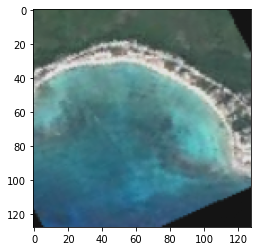

In [100]:
test = next(iter(trainloader))[0][0]
print(test.shape)
img = test.permute(1,2,0)
print(img.shape)
plt.imshow(img.numpy())

plt.show()

We define the Convolutional Neural Network using Convolutional layers, reLu activation, MaxPool normalisation. <br>
We finish the network with a simple fully connected network with reLu activation.<br>
We do not use softmax here because it is already in the criterion.

In [30]:
#Defining CNN architecture

class Conv_Net(nn.Module):
    def __init__(self):
        super().__init__() #3*128*128
        self.conv1a = nn.Conv2d(3, 16, 3, 1, 1) #16*128*128
        self.conv1b = nn.Conv2d(16, 64, 3, 1, 1) #64*128*128
        self.pool1 = nn.MaxPool2d(2, 2) #64*64*64
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1) #128*64*64
        self.pool2 = nn.MaxPool2d(2, 2) #128*32*32
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1) #256*32*32
        self.pool3 = nn.MaxPool2d(2, 2) #256*16*16
        self.conv4 = nn.Conv2d(256, 512, 3, 1, 1) #512*16*16
        self.pool4 = nn.MaxPool2d(2, 2) #512*8*8
        self.conv5 = nn.Conv2d(512, 512, 3, 1, 1) #512*8*8
        self.pool5 = nn.MaxPool2d(2, 2) #512*4*4
        self.fc1 = nn.Linear(512 * 4 * 4, 4096)
        self.fc2 = nn.Linear(4096, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 13)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1b(F.relu(self.conv1a(x)))))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))
        x = x.view(-1, 512 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Initialising GPU device, criterion which is the loss function and the optimizer which will tune the learning rate during the training.

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

PATH = "to_submit/model_v5.pth"

net = Conv_Net().to(device)
net.load_state_dict(torch.load(PATH)) #comment to get new network
net = net.float()

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.0002)

The following cell trains the network, evaluates it each 20 epochs and saves the models if the accuracy is the best it has ever seen.

In [365]:
#train loop

max_acc_val = 0

train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

epoch = 10000

for i in range(epoch):
    data = next(iter(trainloader))
    images, targets = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = net(images.float())
    lossT = criterion(outputs, torch.max(targets, 1)[1])
    lossT.backward()
    optimizer.step()
    #print('RAM memory % used:', psutil.virtual_memory())
    if i%20 == 0:
        net.eval()
        optimizer.zero_grad()
        valid_data = next(iter(validloader))
        imagesV, targetsV = valid_data[0].to(device), valid_data[1].to(device)
        outV = net(imagesV.float())
        lossV = criterion(outV, torch.max(targetsV, 1)[1])
        t_acc = torch.sum(torch.max(outputs, 1)[1] == torch.max(targets,1)[1])/outputs.shape[0]
        v_acc = torch.sum(torch.max(outV, 1)[1] == torch.max(targetsV,1)[1])/outV.shape[0]
        print(f"epoch n{round(i/20)}")
        print(f"train loss: {lossT}      train accuracy: {t_acc}")
        print(f"valid loss: {lossV}      valid accuracy: {v_acc}")
        print("---------------------------------------------------")
        train_loss.append(lossT.detach().item())
        valid_loss.append(lossV.detach().item())
        train_acc.append(t_acc.detach().item())
        valid_acc.append(v_acc.detach().item())
        
        if v_acc > max_acc_val:
            max_acc_val = v_acc
            PATH = f"models/model_{v_acc}.pth"
            torch.save(net.state_dict(), PATH)
        
        net.train()
        del imagesV, targetsV, valid_data, outV, t_acc, v_acc, lossV

epoch n0
train loss: 0.47365859150886536      train accuracy: 0.8671875
valid loss: 0.2757543921470642      valid accuracy: 0.931640625
---------------------------------------------------
epoch n1
train loss: 0.14973948895931244      train accuracy: 0.9375
valid loss: 0.2026064544916153      valid accuracy: 0.921875
---------------------------------------------------
epoch n2
train loss: 0.3533196449279785      train accuracy: 0.875
valid loss: 0.3108695447444916      valid accuracy: 0.908203125
---------------------------------------------------
epoch n3
train loss: 0.2666440010070801      train accuracy: 0.8828125
valid loss: 0.3403773307800293      valid accuracy: 0.896484375
---------------------------------------------------
epoch n4
train loss: 0.3824118375778198      train accuracy: 0.8984375
valid loss: 0.27117204666137695      valid accuracy: 0.9140625
---------------------------------------------------
epoch n5
train loss: 0.20616541802883148      train accuracy: 0.9375
valid

KeyboardInterrupt: 

We plot the loss of the train/validation set

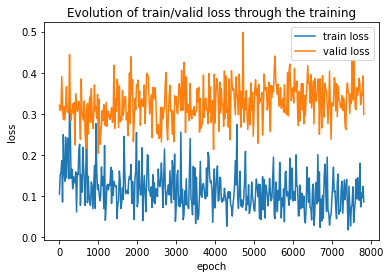

In [178]:
plt.plot(np.arange(0,len(train_loss)*20, 20), train_loss, label = 'train loss')
plt.plot(np.arange(0,len(valid_loss)*20, 20), valid_loss, label = 'valid loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Evolution of train/valid loss through the training')
plt.legend()

We plot the accuracy of the train/validation set

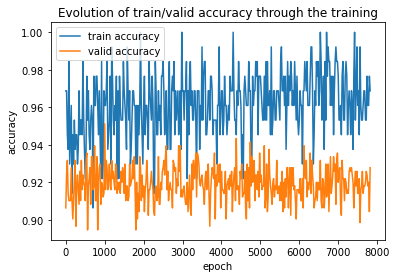

In [179]:
plt.plot(np.arange(0,len(train_acc)*20, 20), train_acc, label = 'train accuracy')
plt.plot(np.arange(0,len(valid_acc)*20, 20), valid_acc, label = 'valid accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Evolution of train/valid accuracy through the training')
plt.legend()

We transform the test data into Pytorch Tensors 

In [32]:
#Predicting for submission

image_test = []

for image in xs['test']:
    image_test.append(ToTensor()(image.reshape(128,128,-1)))

image_test = torch.stack(image_test)

print(image_test.shape)

torch.Size([1950, 3, 128, 128])


In [33]:
print(xs['test'][0])
print(image_test[0])

[0.23529412 0.33333333 0.49019608 ... 0.25490196 0.34901961 0.52941176]
tensor([[[0.2353, 0.2353, 0.2392,  ..., 0.2314, 0.2314, 0.2314],
         [0.2235, 0.2275, 0.2314,  ..., 0.2314, 0.2314, 0.2314],
         [0.2196, 0.2235, 0.2275,  ..., 0.2314, 0.2314, 0.2314],
         ...,
         [0.2431, 0.2431, 0.2431,  ..., 0.2431, 0.2471, 0.2471],
         [0.2471, 0.2471, 0.2471,  ..., 0.2431, 0.2471, 0.2510],
         [0.2471, 0.2471, 0.2471,  ..., 0.2431, 0.2510, 0.2549]],

        [[0.3333, 0.3333, 0.3373,  ..., 0.3059, 0.3059, 0.3059],
         [0.3216, 0.3255, 0.3294,  ..., 0.3059, 0.3059, 0.3059],
         [0.3137, 0.3216, 0.3216,  ..., 0.3059, 0.3059, 0.3059],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.3373, 0.3412, 0.3412],
         [0.3373, 0.3373, 0.3373,  ..., 0.3373, 0.3412, 0.3451],
         [0.3373, 0.3373, 0.3373,  ..., 0.3373, 0.3451, 0.3490]],

        [[0.4902, 0.4902, 0.4941,  ..., 0.4745, 0.4745, 0.4745],
         [0.4824, 0.4824, 0.4902,  ..., 0.4745, 0.4

The following function passes the data through the network while applying some data augmentation if instructed. <br>
The data augmentation on an image creates 5 images who pass through a transformer, they all get a prediction and we choose the most seen prediction as the final one for the given image.

In [34]:
def pred(images, net_PATH, batch_size = 400, augment_mode = False):
    #batch_size is the number of images passing through the network at the same time, its value depends on the GPU RAM size
    out = []
    net = Conv_Net().to(device)
    net.load_state_dict(torch.load(PATH))
    net = net.float()
    net.eval()
    
    if augment_mode:
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(128),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
        ])
        aug_images = []
        for i in range(images.shape[0]):
            aug = [images[i]]
            for j in range(5): #we create 5 more images which will pass in the transformers
                aug.append(transform(images[i]))
            aug_images.append((torch.cat(aug)))
        images = torch.reshape(torch.cat(aug_images), (images.shape[0]*6,3,128,128))

    nb_batches = images.shape[0]/batch_size
    last_b_size = int(np.round(batch_size*(nb_batches - np.floor(nb_batches))))
    if last_b_size == 0: last_b_size = batch_size
    nb_batches = int(np.ceil(nb_batches))
    print(nb_batches, last_b_size)
    for i in range(nb_batches):
        if i != nb_batches-1:
            out.append(torch.max(net(images[i*batch_size:(i+1)*batch_size].float()), axis = 1)[1])
        else:
            out.append(torch.max(net(images[i*batch_size:(i*batch_size + last_b_size)].float()), axis = 1)[1])
    if augment_mode:
        out = torch.reshape(torch.cat(out), (int(images.shape[0]/6), 6))
        return torch.mode(out, dim = 1)[0].tolist()
    return torch.cat(out).tolist()

In [35]:
PATH = "to_submit/model_v5.pth"

We test the prediction on the valid set with and without the augmentation method

In [ ]:
#Testing on valid set

p_a = pred(image_valid, PATH, augment_mode = True) #prediction with augmentation
p = pred(image_valid, PATH) #prediction without augmentation

In [ ]:
print("Augmented prediction score: ", float(sum(torch.Tensor(p_a) == torch.max(label_valid, dim = 1)[1])/len(p_a)))
print("Standard prediction score: ", float(sum(torch.Tensor(p) == torch.max(label_valid, dim = 1)[1])/len(p_a)))

We get better accuracy with augmented prediction method

We prepare the data for submissionPATH = "to_submit/model_v5.pth"

In [ ]:
PATH = "to_submit/model_v5.pth"

In [49]:
#test_pred =pred(image_test, PATH, augment_mode = True) #prediction with augmentation
test_pred = pred(image_test, PATH, augment_mode=True) #prediction without augmentation

30 100


The following function make the file to submit

In [53]:
import shutil
import os

def make_submission(pred, delete_file = True):
        '''Create a submission zip
           pred should be an iterable collection of int
           make sure the prediction is in the right order'''
        output_filename = "Areal_test"
        dir_name = "."
        if not os.path.exists(output_filename):
             os.makedirs(output_filename)
        file = open(output_filename +'/'+ output_filename + '.predict', "w")
        for i in pred:
            file.write(str(i) + '\n')
        file.close()
        shutil.make_archive(output_filename, 'zip', output_filename)
        if delete_file:
            shutil.rmtree(output_filename)
        print("Submission Ready")

In [54]:
make_submission(test_pred)

Submission Ready


We apply a PCA to the dataset

In [36]:
#PCA for non-pytorch approches

N_COMP = 40  # 300 1000

scaler = StandardScaler()
pca = decomposition.PCA(n_components=N_COMP)

preproc_pipe = pipeline.Pipeline(steps=[("scaler", scaler), ("pca", pca)])  

preproc_pipe.fit(xs["train"])

xps = {
    data_set: preproc_pipe.transform(xs[data_set]) 
    for data_set in ALL_SETS
}

print(xps["train"].shape)

(3900, 40)


In [37]:
print(pca.explained_variance_ratio_.shape)

print(f"{pca.explained_variance_ratio_.cumsum()[-1]:.3f}")

# with np.printoptions(precision=3):
#     print(pca.explained_variance_ratio_.cumsum())

(40,)
0.799


We train different models in sklearn and print the accuracy score on the train set and the validation set

In [38]:
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = [
    naive_bayes.GaussianNB(),
    Perceptron(tol=1e-3, random_state=0),
    KNeighborsClassifier(n_neighbors=3),
    LinearSVC(random_state=0, tol=1e-5),
    ensemble.RandomForestClassifier(n_estimators=10),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
    MLPClassifier(random_state=1, max_iter=500,hidden_layer_sizes = [200,100,50,25]),
]

for model in models:
    print(model)
    model.fit(xps["train"], np.argmax(ys["train"], axis = 1))  # training 
     
    pred = {
    data_set: model.predict(xps[data_set]) 
    for data_set in ALL_SETS
    }
    
    print(sklearn.metrics.accuracy_score(np.argmax(ys["train"], axis = 1),pred['train']))
    print(sklearn.metrics.accuracy_score(np.argmax(ys["valid"], axis = 1),pred['valid']))

GaussianNB()
0.4856410256410256
0.4623076923076923
Perceptron()
0.20282051282051283
0.18923076923076923
KNeighborsClassifier(n_neighbors=3)
0.6569230769230769
0.45384615384615384
LinearSVC(random_state=0, tol=1e-05)


C:\Users\Clement\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.2230769230769231
0.21923076923076923
RandomForestClassifier(n_estimators=10)
0.9946153846153846
0.5123076923076924
GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)
0.38897435897435895
0.34384615384615386
MLPClassifier(hidden_layer_sizes=[200, 100, 50, 25], max_iter=500,
              random_state=1)
0.9861538461538462
0.5338461538461539


We search the best hyper-parameters for RandomForestClassifier using RandomizedSearchCV with Cross Validation

In [43]:
from sklearn.model_selection import RandomizedSearchCV

distribution = dict(n_estimators=[5,10,50,100,200],
                    min_samples_split=[2,3,5,10],
                    min_samples_leaf=[1,2,3,4,5],
                    max_features=['auto', 'sqrt', 'log2'])
            
CV = 10
    
RandomForestClassifier = ensemble.RandomForestClassifier()
clf = RandomizedSearchCV(RandomForestClassifier,distribution, cv=CV)
search = clf.fit(xps["valid"], np.argmax(ys["valid"], axis = 1))
search.best_params_

{'n_estimators': 200,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'sqrt'}

In [45]:
model = ensemble.RandomForestClassifier(n_estimators=200,min_samples_split=5, min_samples_leaf=5, max_features='auto')

model.fit(xs["train"], np.argmax(ys["train"], axis = 1))    # WITH PCA: xps, Without PCA: xs

RandomForestClassifier(min_samples_leaf=5, min_samples_split=5,
                       n_estimators=200)

In [41]:
# WITH PCA: xps, Without PCA: xs
pred_pca = {
    data_set: model.predict(xs[data_set]) 
    for data_set in ALL_SETS
}

ValueError: Number of features of the model must match the input. Model n_features is 40 and input n_features is 49152 

In [ ]:
print(sklearn.metrics.accuracy_score(np.argmax(ys["train"], axis = 1),pred['train']))
print(sklearn.metrics.accuracy_score(np.argmax(ys["valid"], axis = 1),pred['valid']))

## Scoring the result

In [64]:
PATH = "to_submit/model_v5.pth"

pred_cm = pred(image_valid, PATH)

4 100


'CNN_dataAugcomplex'### confusion matrix

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Confusion Matrix for best model

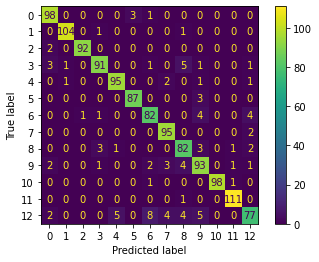

In [102]:
cm = confusion_matrix( np.argmax(ys['valid'], axis = 1).reshape(-1), pred_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.arange(0,13,1))
disp.plot()


Displaying names corresponding to label indices

In [104]:
names = ['beach','chaparral','cloud','desert','forest','island','lake','meadow','mountain','river','sea','snowberg','wetland']

for i in range(len(names)):
    print(f"{i} corresponds to {names[i]} \n")

0 corresponds to beach 

1 corresponds to chaparral 

2 corresponds to cloud 

3 corresponds to desert 

4 corresponds to forest 

5 corresponds to island 

6 corresponds to lake 

7 corresponds to meadow 

8 corresponds to mountain 

9 corresponds to river 

10 corresponds to sea 

11 corresponds to snowberg 

12 corresponds to wetland 



In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
plot_confusion_matrix(, , , cmap=plt.cm.Blues, ax=ax)
plt.show()

In [105]:
methods = ['CNN', 'CNN_dataAugbasic', 'CNN_dataAugcomplex','CNN_dataAugcomplex/LearingRateTweak', 'CNN_dataAug/PredAug']
scores = [0.7805128205,0.8748717949,0.9087179487,0.9179487179,0.9261538462] #Values from Codalab

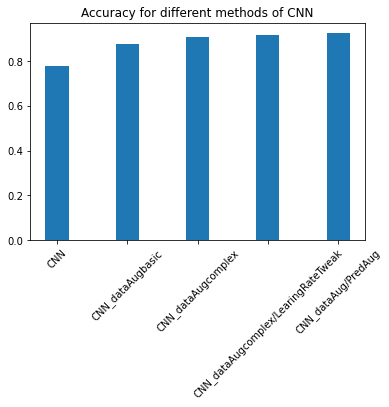

In [120]:
plt.bar(methods, scores, width = 0.33)
plt.title('Accuracy for different methods of CNN')
plt.xticks(rotation=45)
plt.show()

In [128]:
methods = ['GaussianNB', 'Perceptron', 'KNeighborsClassifier','LinearSVC','RandomForestClassifier', 'GradientBoostingClassifier','MLPClassifier','RandomForestClassifierWithGridSearch/CV']
scores = [0.46307692307692305,0.21846153846153846,0.4592307692307692,0.22230769230769232,0.5061538461538462,0.07307692307692308,0.5207692307692308,0.6338461538461538] #Values from validation set

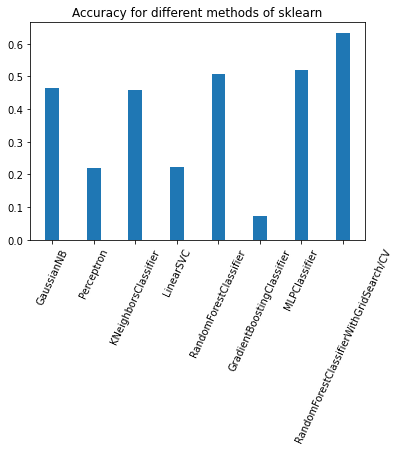

In [131]:
plt.bar(methods, scores, width = 0.33)
plt.title('Accuracy for different methods of sklearn')
plt.xticks(rotation=65)
plt.show()

Conclusion:<br><br>

As shown by the previous plots, the Pytorch Models significantly outperform sklearn models. <br>
Some very simple approaches like LinearSVC or GradientBoosting clearly failed at achieving this task.<br>
Looking at their complexity, it was expected. Focusing on the pytorch approch allowed us to test data augmentation related to images with the transform module. <br>
If we had more time, we would have tested different CNN techniques such as residual layers used a lot in image classification. We could have increased our accuracy score using a CNN like ResNet50 pre-trained on imageNet.

Note:<br>
The final accuracy score on Phase 2 with the best model is 0.938974359.